In [117]:
## load files 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectorMixin
from sklearn.metrics import class_likelihood_ratios, confusion_matrix, accuracy_score
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml

In [118]:
class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names=None):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        if self.feature_names:
             for col in self.feature_names:
                if col in X.columns:
                    Q1 = X[col].quantile(0.25)
                    Q3 = X[col].quantile(0.75)
                    IQR = Q3 - Q1
                    self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        X_copy = X.copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X_copy.columns:
                mask = (X_copy[col] < lower) | (X_copy[col] > upper)
                X_copy.loc[mask, col] = np.nan
        return X_copy

In [119]:
class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, variance_percentile=0.10, corr_threshold=0.1, check_stability=True):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold
        self.check_stability = check_stability
        self.selected_indices_ = []
        self.n_features_in_ = 0

    def fit(self, X, y=None):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.n_features_in_ = X.shape[1]
        df = pd.DataFrame(X)

        # 1. Variance
        variances = df.var()
        threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > threshold

        # 2. Correlation
        if y is not None:
            y_series = pd.Series(y).reset_index(drop=True)
            df_reset = df.reset_index(drop=True)
            correlations = df_reset.corrwith(y_series).abs().fillna(0)
            high_corr_mask = correlations > self.corr_threshold
        else:
            high_corr_mask = pd.Series([False] * len(df.columns))

        # 3. Stability
        stable_mask = pd.Series([True] * len(df.columns))
        if self.check_stability:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            stability_scores = []
            for train_idx, _ in kf.split(df):
                split_var = df.iloc[train_idx].var()
                stability_scores.append(split_var)
            stability_df = pd.DataFrame(stability_scores)
            stability_std = stability_df.std()
            mean_std = stability_std.mean()
            if mean_std > 0:
                 stable_mask = stability_std < (mean_std * 2)

        final_mask = (high_variance_mask | high_corr_mask) & stable_mask
        self.selected_indices_ = np.where(final_mask)[0]
        
        if len(self.selected_indices_) == 0:
            self.selected_indices_ = np.arange(X.shape[1])
        return self

    def _get_support_mask(self):
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

In [ ]:
## Clean Data
def clean_df(col):
    col = col.strip().lower()
    col = re.sub(r'[\^]', '_', col)
    col = col.strip('_')
    return col

In [ ]:
## Load Dataset
df = fetch_openml(name='adult', version=2, as_frame=True).frame
df.columns = [clean_df(col) for col in df.columns]

In [122]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [124]:
df.shape

(48842, 15)

In [125]:
## Remove duplicate
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [126]:
## Replace Dtype
df["class"] = (df["class"].map({
    "<=50K":0,
    ">50K":1
    
}).astype("int64"))

In [127]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1


In [128]:
## Checking unique values
for col in df.columns:
    print(col, " : ", df[col].nunique())

age  :  74
workclass  :  8
fnlwgt  :  28523
education  :  16
education-num  :  16
marital-status  :  7
occupation  :  14
relationship  :  6
race  :  5
sex  :  2
capital-gain  :  123
capital-loss  :  99
hours-per-week  :  96
native-country  :  41
class  :  2


In [129]:
df["fnlwgt"].unique()

array([226802,  89814, 336951, ..., 129912, 255835, 257302],
      shape=(28523,))

In [130]:

df.isnull().sum()

age                  0
workclass         2795
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     856
class                0
dtype: int64

In [132]:
X = df.drop(df[["class"]], axis=1)
Y = df["class"]

In [133]:
## Split X, Y in Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [134]:
numerical_col = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_col = X_train.select_dtypes(include='object').columns.tolist()

In [135]:
skewness = X_train[numerical_col].apply(lambda x: x.skew()).abs()
skew_threshold = 0.5

In [136]:
skew_cols = skewness[skewness >= skew_threshold].index.tolist()
norm_cols = list(set(numerical_col) - set(skew_cols))

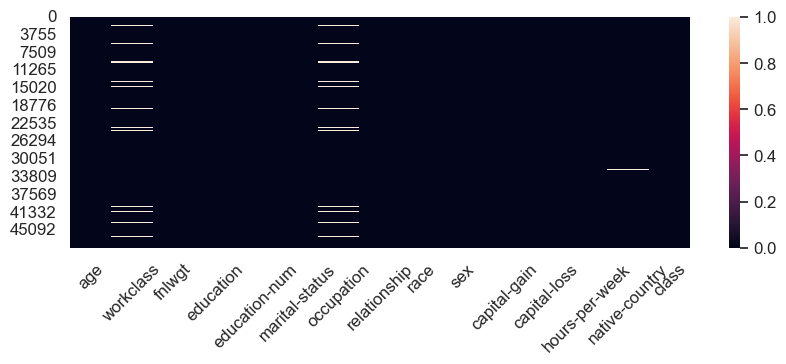

In [150]:
plt.figure(figsize=(10, 3))
sns.heatmap(df.isnull())
plt.xticks(rotation=45)
plt.show()

In [137]:
skew_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=skew_cols)),
    ('imputer', SimpleImputer(strategy="median")),
    ('Transformer', PowerTransformer(method='yeo-johnson')),
    ('StandardScaler', StandardScaler())
])

<Figure size 1800x1400 with 0 Axes>

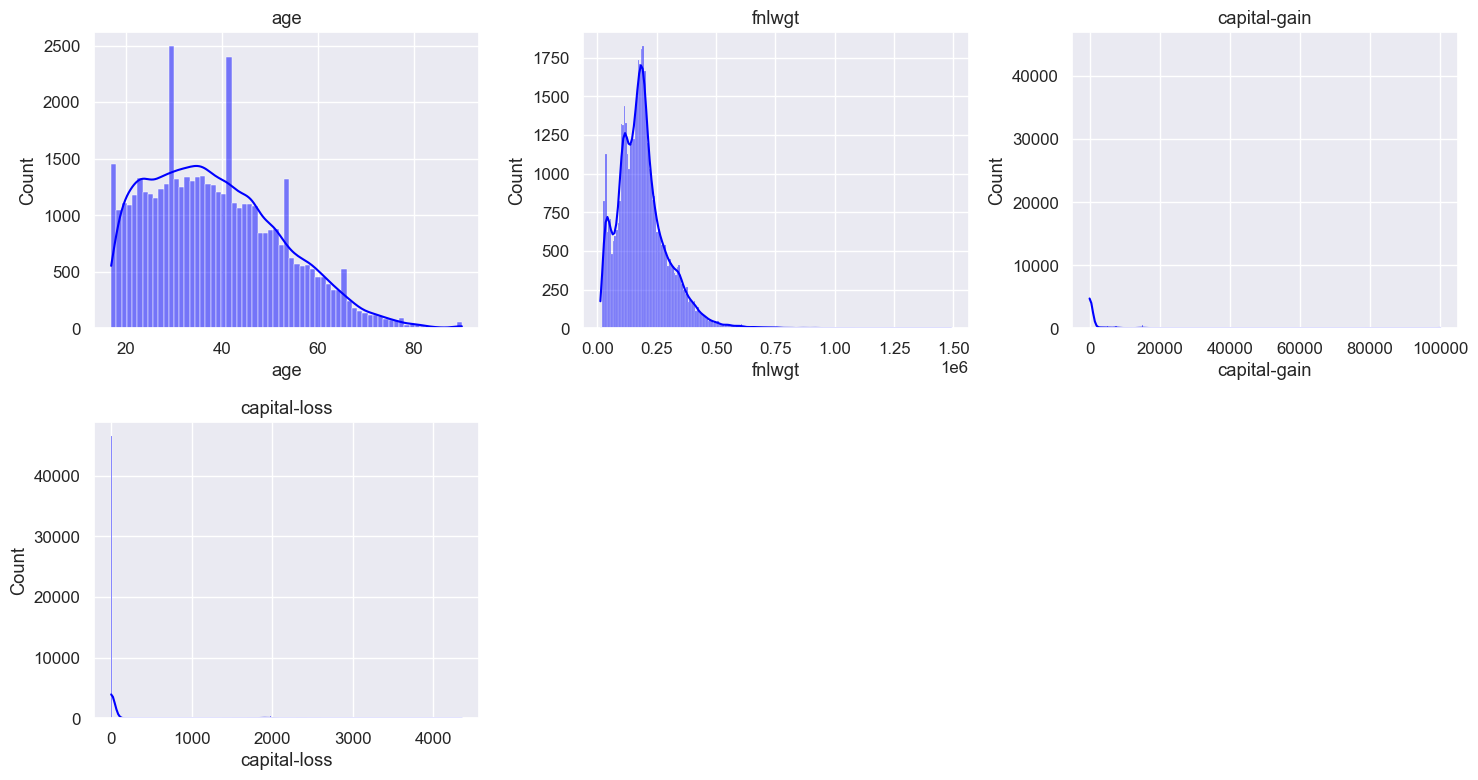

In [153]:
import math
plt.figure(figsize=(18, 14))
cols = df[skew_cols].select_dtypes(include=np.number).columns
total = len(cols)
rows = math.ceil(total/3)
plt.figure(figsize=(15, rows* 4))

for i, col in enumerate(cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(col)

plt.tight_layout()
plt.show()

In [138]:
norm_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=norm_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('Normalization', MinMaxScaler())
])

In [139]:
cat_subpipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('OneHotEncoding', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
    # ('LabelEncoder', LabelEncoder()),
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

])

In [140]:
preprocessor = ColumnTransformer([
    ('skew', skew_subpipe, skew_cols),
    ('norm', norm_subpipe, norm_cols),
    ('cat', cat_subpipe, categorical_col)
], remainder='drop')

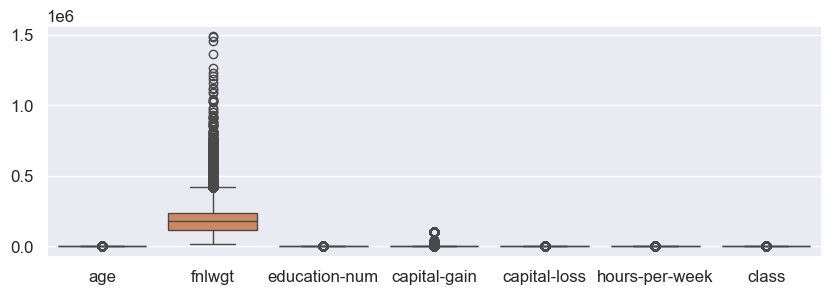

In [141]:
## Outliers
plt.figure(figsize=(10, 3))
sns.boxplot(df.select_dtypes(include=np.number))
plt.show()

In [142]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', AdvancedFeatureSelector(variance_percentile=0.10, corr_threshold=0.05)),
    # ('model', LogisticRegression(class_weight='balanced'))
    ('Decision_Tree_Classifier', DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, max_features='sqrt', min_samples_split=20, max_leaf_nodes=30))
])

In [143]:
final_pipeline.fit(X_train, Y_train)

c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skew', ...), ('norm', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [144]:
final_pipeline.score(X_test, Y_test)*100

78.19225251076041

In [145]:
print("=== Training Base Model ===")
final_pipeline.fit(X_train, Y_train)
y_pred = final_pipeline.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(f"Base Model Accuracy: {acc * 100:.2f}%")

=== Training Base Model ===


c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Base Model Accuracy: 78.19%


In [146]:
print("-" * 50)
print("Running Grid Search (This may take a moment)...")

param_grid = {
    'feature_selection__variance_percentile': [0.05, 0.10],
    'Decision_Tree_Classifier__max_depth': [10, 20, 30],
    'Decision_Tree_Classifier__min_samples_leaf': [10, 20],
    'Decision_Tree_Classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print(f"\nBest Tuned Accuracy: {grid_search.best_score_ * 100:.2f}%")
print(f"Best Parameters: {grid_search.best_params_}")

--------------------------------------------------
Running Grid Search (This may take a moment)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Tuned Accuracy: 78.30%
Best Parameters: {'Decision_Tree_Classifier__criterion': 'entropy', 'Decision_Tree_Classifier__max_depth': 10, 'Decision_Tree_Classifier__min_samples_leaf': 20, 'feature_selection__variance_percentile': 0.05}


c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


--------------------------------------------------
Generating Heatmap...


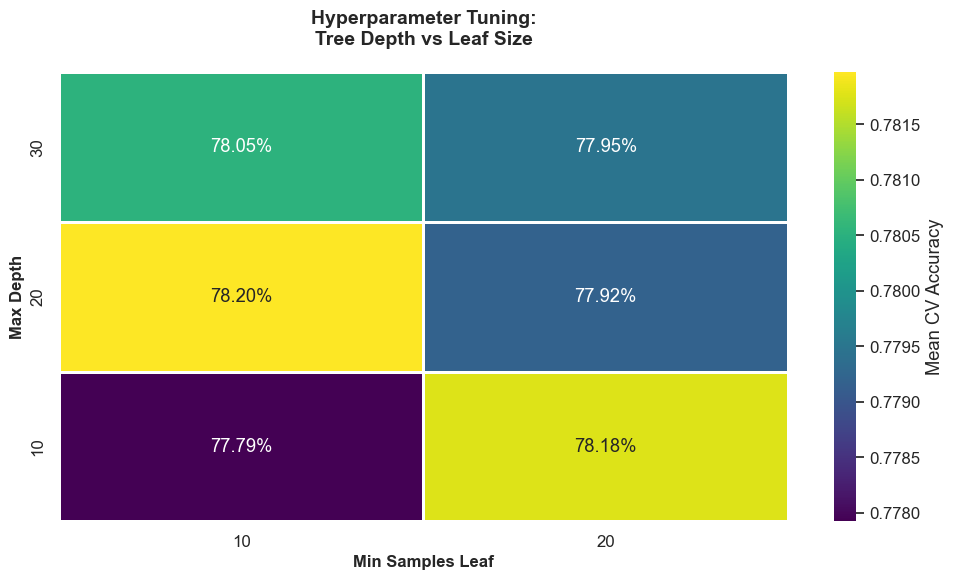

In [147]:
print("-" * 50)
print("Generating Heatmap...")

results_df = pd.DataFrame(grid_search.cv_results_)

# Grouping by Depth and Leaf to visualize 2D
heatmap_data = results_df.groupby([
    'param_Decision_Tree_Classifier__max_depth', 
    'param_Decision_Tree_Classifier__min_samples_leaf'
])['mean_test_score'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,            
    fmt=".2%",             
    cmap='viridis',        
    cbar_kws={'label': 'Mean CV Accuracy'},
    linewidths=1,          
    linecolor='white'
)

plt.title('Hyperparameter Tuning:\nTree Depth vs Leaf Size', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Min Samples Leaf', fontsize=12, fontweight='bold')
plt.ylabel('Max Depth', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

--------------------------------------------------
Running Grid Search (This may take a moment)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Noman Traders\Desktop\WebDevCourse\my projects\Learn Python\02-py-libraries\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Best Tuned Accuracy: 78.29%
Best Parameters: {'Decision_Tree_Classifier__criterion': 'gini', 'Decision_Tree_Classifier__max_depth': 30, 'Decision_Tree_Classifier__min_samples_leaf': 10, 'feature_selection__variance_percentile': 0.1}
--------------------------------------------------
Generating Heatmap...


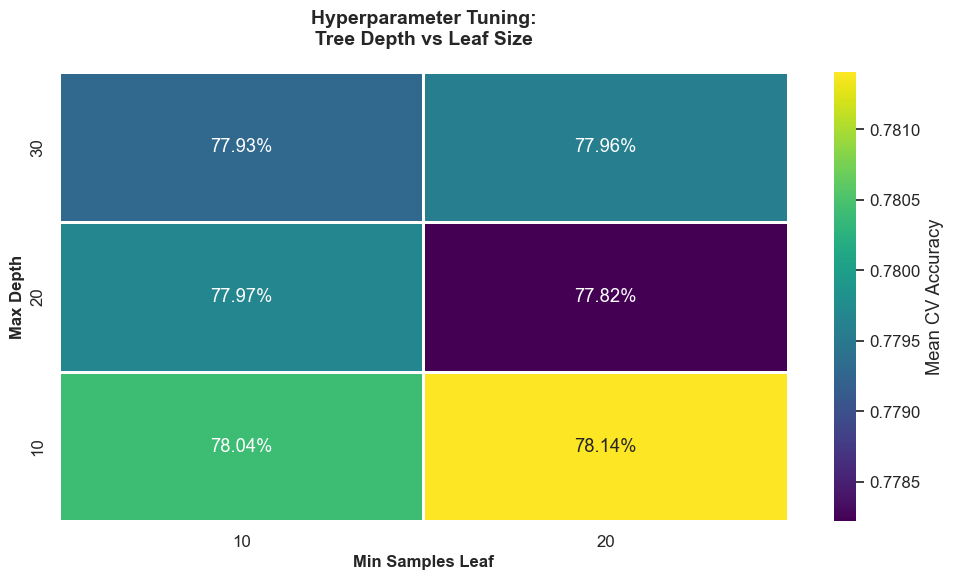

In [148]:
# Tuning
print("-" * 50)
print("Running Grid Search (This may take a moment)...")

param_grid = {
    'feature_selection__variance_percentile': [0.05, 0.10],
    'Decision_Tree_Classifier__max_depth': [10, 20, 30],
    'Decision_Tree_Classifier__min_samples_leaf': [10, 20],
    'Decision_Tree_Classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print(f"\nBest Tuned Accuracy: {grid_search.best_score_ * 100:.2f}%")
print(f"Best Parameters: {grid_search.best_params_}")

## Visaulizing Heatmap
print("-" * 50)
print("Generating Heatmap...")

results_df = pd.DataFrame(grid_search.cv_results_)

# Grouping by Depth and Leaf to visualize 2D
heatmap_data = results_df.groupby([
    'param_Decision_Tree_Classifier__max_depth', 
    'param_Decision_Tree_Classifier__min_samples_leaf'
])['mean_test_score'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,            
    fmt=".2%",             
    cmap='viridis',        
    cbar_kws={'label': 'Mean CV Accuracy'},
    linewidths=1,          
    linecolor='white'
)

plt.title('Hyperparameter Tuning:\nTree Depth vs Leaf Size', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Min Samples Leaf', fontsize=12, fontweight='bold')
plt.ylabel('Max Depth', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()